# 🍔👁 Food Vision: fine tunning Efficentnet with food_101 dataset

In these notebook I`m going to build a transfer learning model which beat the original results of the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with only 10% of the data for training (25250 training images and 7570 testing images). After that, I'm going to reproduce the same model with all of the data from the Food101 dataset.
The goal to achive for these project is **beat [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network **trained for 2-3 days to achieve 77.4% top-1 accuracy**.

In these project you can see the following steps:
- 1. Creation of a small CNN to see how they works
- 2. Transfer Learning with the [EfficientNet](https://arxiv.org/abs/1905.11946) model, a state of the art computer vision architecture trained with [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks. In these case, I'm going to use the 10% of the data of the Food_101 dataset.
- 3. Fine tune the [EfficientNet](https://arxiv.org/abs/1905.11946) model with 10 % of the data.
- 4. Develop the same EfficentNet model as above but with the **100% of the Food_101 dataset**.


In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-12-03 16:53:37.237552


- In the repository you can download the *helper_functions.py* file, with developed functions that are so useful for these and other projects of Convolutional Neural Networks

In [2]:
# Get helper functions file
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/Garcialejan/Computer_vision_food_classification/refs/heads/main/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import plot_loss_curves, walk_through_dir, create_checkpoint_callback, compare_historys, make_confusion_matrix, load_and_prep_image

2024-12-03 16:53:38.057336: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 16:53:38.241972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733241218.311970     886 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733241218.331402     886 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 16:53:38.503702: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

- Now, I'm going to import some of the modules that we need to run the code, check the tensorflow version and check if we are using the GPU for run our models.

In [4]:
import tensorflow as tf

In [5]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [6]:
# Get GPU name
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4060 Ti (UUID: GPU-0cb8d0d0-b8f3-ea57-552f-290eacf87dec)


In [7]:
# I reduce the logs outputs with:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only shows warnings and errors

# Models with 10 % of the data

## 1. Loading the data.

In [8]:
train_dir = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/train"
test_dir = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test"

In [9]:
walk_through_dir("/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/")

There are 2 directories and 0 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/'.
There are 101 directories and 0 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test'.
There are 0 directories and 75 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 75 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/donuts'.
There are 0 directories and 75 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/sushi'.
There are 0 directories and 75 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 75 images

There are 0 directories and 250 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/train/breakfast_burrito'.
There are 0 directories and 250 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories and 250 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/train/guacamole'.
There are 0 directories and 250 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 250 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 250 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_perc

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image_direct(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir + "/" +target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (384, 512, 3)


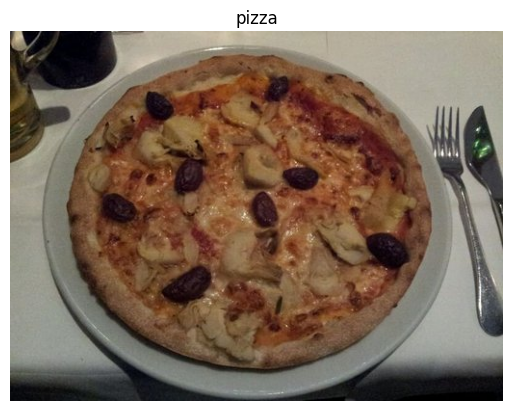

In [11]:
img = view_random_image_direct(target_dir=train_dir, target_class="pizza")

In [12]:
img

array([[[ 67,  65,  68],
        [ 58,  54,  53],
        [ 87,  82,  76],
        ...,
        [179, 175, 150],
        [180, 176, 151],
        [180, 176, 151]],

       [[ 62,  58,  59],
        [ 58,  54,  53],
        [ 88,  81,  73],
        ...,
        [175, 171, 146],
        [176, 172, 147],
        [176, 172, 147]],

       [[ 58,  52,  52],
        [ 62,  57,  53],
        [ 87,  80,  70],
        ...,
        [173, 169, 144],
        [173, 169, 144],
        [173, 169, 144]],

       ...,

       [[  8,   9,  13],
        [  6,   7,  11],
        [  5,   6,  10],
        ...,
        [  2,   3,   5],
        [  1,   2,   4],
        [  2,   3,   5]],

       [[  8,   9,  13],
        [  6,   7,  11],
        [  4,   5,   9],
        ...,
        [  2,   3,   5],
        [  1,   2,   4],
        [  2,   3,   5]],

       [[ 13,  14,  18],
        [ 10,  11,  15],
        [  8,   9,  13],
        ...,
        [  2,   3,   5],
        [  3,   4,   6],
        [  5,   6,   8]]

In [13]:
print(img.min(), img.max())

0 255


- Looking at the image shape more closely, you'll see it's in the form `(Width, Height, Colour Channels)`
- All of the values in the `img` array are between 0 and 255. This is because that's the possible range for red, green and blue values.
- To work with normalize data, we are going to use one of the most common preprocessing steps for working with images, which is to **scale** (also referred to as **normalize**) the pixel values by dividing the image arrays by 255. We are going to do this step of normalize the data in a layer using the Sequential API of tensorflow.

- Let's use the [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) function to turn our images and labels into a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), a TensorFlow datatype which allows for us to pass it directory to our model.

In [ ]:
# Create data inputs 
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # Multiclass classification problem
                                                                            batch_size=32, # To avoid memory problems
                                                                            shuffle = True) 

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           shuffle = False) # don't shuffle test data for prediction analysis (point 5 of the nb)

Found 25250 files belonging to 101 classes.


I0000 00:00:1733241223.424242     886 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 7575 files belonging to 101 classes.


In [15]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

- The `batch_size` is `None` due to it only being used during model training. You can think of `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

In [16]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

- I'm going to create a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callbacks to save the progress during training. This means I could experiment with further training later without having to train from scratch every time.
- This maybe is making non sense to you becouse I'm developing a small CNN, however this callback will be useful when we see the EfficentNet transfer learning and fine tunning models.  

In [17]:
# Create checkpoint callback to save model for later use
checkpoint_path = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/101_classes_10_percent_data_model/"
checkpoint_name = "model1_checkpoint.weights.h5"

chk_callback_model1 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + checkpoint_name,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

## 2. First CNN: base_model

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

model_1 = tf.keras.models.Sequential([
    layers.Rescaling(1./255,
                     input_shape=(224, 224, 3)),
    layers.Conv2D(filters=10,
                  kernel_size=3, 
                  activation="relu"),
    layers.Conv2D(10, 3, activation="relu"),
    layers.MaxPool2D(pool_size=2, padding="valid"),
    layers.Conv2D(10, 3, activation="relu"),
    layers.Conv2D(10, 3, activation="relu"),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(len(train_data_10_percent.class_names), activation="softmax")
])

/home/alejandro/anaconda3/envs/tensorflow_env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [20]:
# Fit the model
history_1 = model_1.fit(train_data_10_percent,
                        epochs=5,
                        validation_data=test_data_10_percent,
                        callbacks=[chk_callback_model1])

Epoch 1/5


I0000 00:00:1733241225.835242    3778 service.cc:148] XLA service 0x7f2dc8005480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733241225.836854    3778 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-12-03 16:53:45.868666: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733241225.981873    3778 cuda_dnn.cc:529] Loaded cuDNN version 90300


  8/790 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.0282 - loss: 0.3328

I0000 00:00:1733241228.873971    3778 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


786/790 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0260 - loss: 0.0672

2024-12-03 16:54:01.931436: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_603', 432 bytes spill stores, 336 bytes spill loads

2024-12-03 16:54:02.102915: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_714', 536 bytes spill stores, 536 bytes spill loads

2024-12-03 16:54:02.180117: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_714', 612 bytes spill stores, 612 bytes spill loads



790/790 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.0261 - loss: 0.0671 - val_accuracy: 0.0613 - val_loss: 0.0526
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.0960 - loss: 0.0502 - val_accuracy: 0.0920 - val_loss: 0.0512
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.1910 - loss: 0.0453 - val_accuracy: 0.0883 - val_loss: 0.0542
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.4007 - loss: 0.0347 - val_accuracy: 0.0701 - val_loss: 0.0730
Epoch 5/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.7914 - loss: 0.0154 - val_accuracy: 0.0577 - val_loss: 0.1175


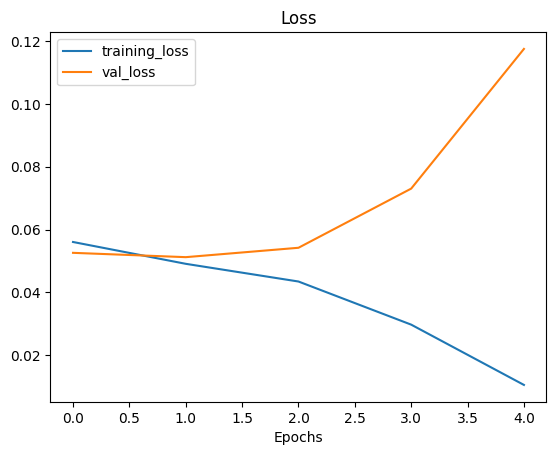

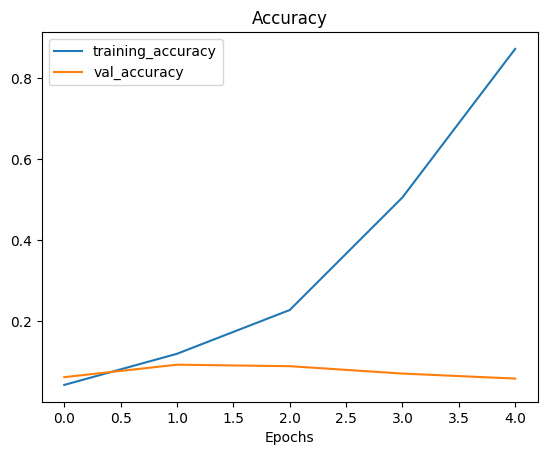

In [21]:
# How does the model go
plot_loss_curves(history_1)

- Well, as you can see, **overfitting** has come to the party. Let's try something to avoid it.
- For the other hand, I'm going to add some extra features to the CNN to get a better accuracy value

In [22]:
model_2 = tf.keras.models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),  
    layers.Conv2D(32, 3, activation="relu"),             # More filters in the initial layers
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(64, 3, activation="relu"),             # We add progressively more filters
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPool2D(pool_size=2),
    layers.Flatten(),
    layers.Dropout(0.5),                                 # Dropout to avoid overfitting
    layers.Dense(128, activation="relu"),                # New fully connected layer
    layers.Dropout(0.5),                                 # More dropout to avoid overfitting
    layers.Dense(len(train_data_10_percent.class_names), activation="softmax")  # Salida softmax
])

In [23]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        validation_data=test_data_10_percent)

Epoch 1/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.0106 - loss: 0.1240 - val_accuracy: 0.0268 - val_loss: 0.0568
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.0161 - loss: 0.0603 - val_accuracy: 0.0380 - val_loss: 0.0547
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.0302 - loss: 0.0581 - val_accuracy: 0.0587 - val_loss: 0.0529
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.0423 - loss: 0.0566 - val_accuracy: 0.0651 - val_loss: 0.0519
Epoch 5/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.0533 - loss: 0.0554 - val_accuracy: 0.0719 - val_loss: 0.0508


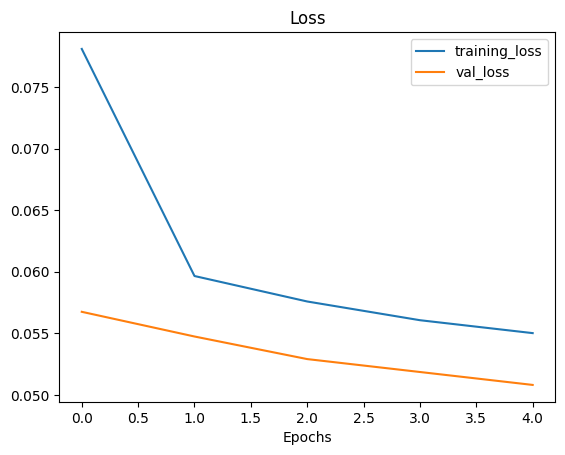

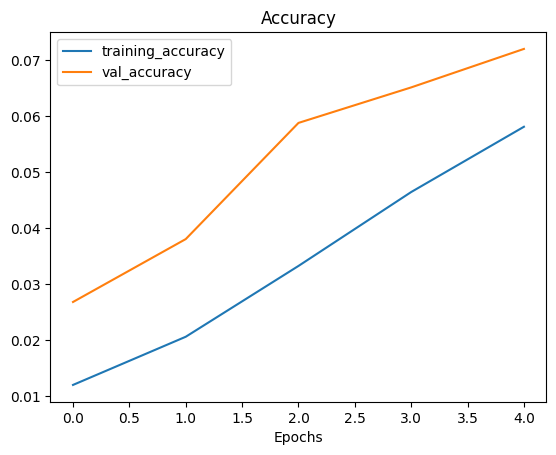

In [24]:
plot_loss_curves(history_2)

- I have reduced the overfitting, however I'm far away from my goal of getting an accuracy better than the [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment) project.

- No problem, to solve this I am going to use transfer learning and fine tunning with the [EfficientNet](https://arxiv.org/abs/1905.11946) model.

## 3. Transfer learning with EfficientNet and 10% of the data

- Now, I'm going to use the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module that contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct the new model. 
- In particular, I'm going to use the [EfficientNet](https://arxiv.org/abs/1905.11946) model setting the `include_top` parameter to `False` (create our own top, which are the output layers for the model).
- Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.

In [25]:
# Reload the images
IMG_SIZE = (224, 224) 
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # Multiclass classification problem
                                                                            batch_size=32, # To avoid memory problems
                                                                            shuffle = True) 

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 25250 files belonging to 101 classes.
Found 7575 files belonging to 101 classes.


In [26]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

### 3.1 Adding data augmentation and normalize images

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar. Doing this simulates the kind of data a model might be used on in the real world.

- To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

In [27]:
data_augmentation = keras.Sequential([
  layers.Input(shape = (224, 224, 3)),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # layers.Rescaling(1./255)
], name ="data_augmentation")

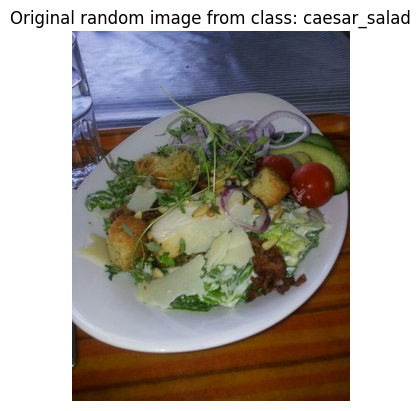

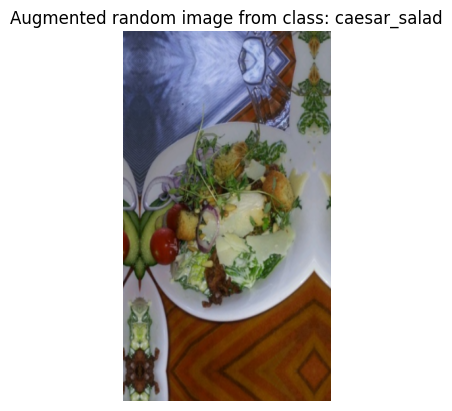

In [28]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_10_percent.class_names) # choose a random class
target_dir = train_dir + "/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image

plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()

plt.imshow(tf.squeeze(augmented_img)/255) # eliminate te batch dimension
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

- The `EfficientNetV2` models in the `tf.keras.applications` module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do

In [ ]:
# We are going to see the summary of the EfficentNetV2 model
# You can see that the 3 layer is a normalization layer
base_model.summary()

### 3.2 Model creation and trainning

In [30]:
def create_transfer_learning_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                                   output_shape: int = 101,
                                   learning_rate: float = 0.001,
                                   training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B3 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

In [31]:
# Create an instance of model_3
model_3 = create_transfer_learning_model()

In [32]:
model_3.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, None, None,     │    12,930,622 │
│                                 │ 1536)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       155,237 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,085,859 (49.92 MB)

 Trainable params: 155,237 (606.39 KB)

 Non-trainable params: 12,930,622 (49.33 MB)

In [33]:
# Create checkpoint callback to save model for later use
checkpoint_path_model3 = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/101_classes_10_percent_data_model/"
checkpoint_name_model3 = "model3_checkpoint.weights.h5"

chk_callback_model3 = create_checkpoint_callback(checkpoint_path_model3,
                                                 checkpoint_name_model3)

In [34]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_3 = model_3.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25 * len(test_data_10_percent)), # do less steps per validation (quicker)
                        callbacks = [chk_callback_model3])

Epoch 1/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 305s 375ms/step - accuracy: 0.2864 - loss: 3.2131 - val_accuracy: 0.5196 - val_loss: 1.8761
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 197s 249ms/step - accuracy: 0.5121 - loss: 1.9167 - val_accuracy: 0.5519 - val_loss: 1.7361
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 152s 192ms/step - accuracy: 0.5492 - loss: 1.7283 - val_accuracy: 0.5779 - val_loss: 1.6229
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 123s 155ms/step - accuracy: 0.5815 - loss: 1.6019 - val_accuracy: 0.5916 - val_loss: 1.6203
Epoch 5/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 106s 134ms/step - accuracy: 0.5914 - loss: 1.5313 - val_accuracy: 0.3913 - val_loss: 2.5366


2024-12-03 17:12:07.504246: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-03 17:12:07.504348: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/alejandro/anaconda3/envs/tensorflow_env/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [35]:
# Evaluate on the test data
results_model_3= model_3.evaluate(test_data_10_percent)
results_model_3

237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.6026 - loss: 1.5625


[1.580496907234192, 0.6001319885253906]

In [36]:
# Load in saved model weights and evaluate model
model_3.load_weights(checkpoint_path_model3 + checkpoint_name_model3)
loaded_weights_model3_results = model_3.evaluate(test_data_10_percent)

237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.6042 - loss: 1.5779


In [37]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_model_3), np.array(loaded_weights_model3_results))

array([False, False])

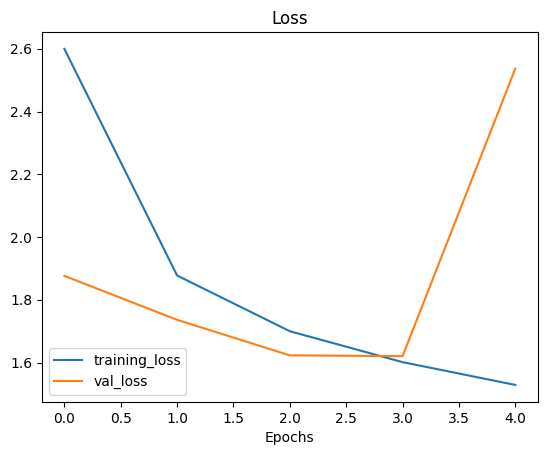

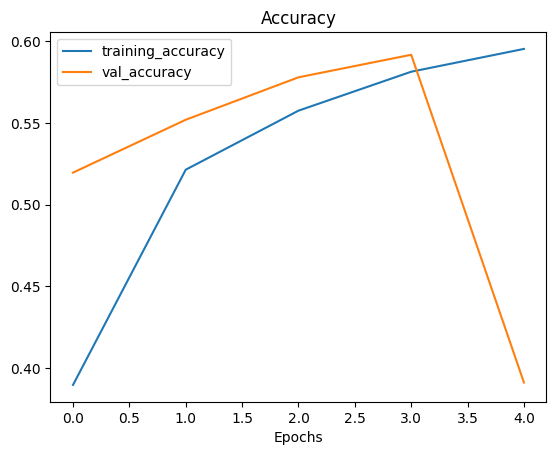

In [38]:
# Plot model loss curves
plot_loss_curves(history_3)

- So nice!! I take a near 60% of accuracy with only 10% of the data thanks to transfer learning!!
- And it's not over yet, now I'm going to implement fine-tunnning to try to improve the accuracy of fine-tunnning even more.

## 4. Fine tunning with EfficientNet and 10% of the data

- The feature extraction transfer learning model performs well, but now I'm going to try to **fine-tune a few layers** in the base model and see if I take any improvement.The good news is, thanks to the `ModelCheckpoint` callback, I've got the saved weights of the already well-performing model so if fine-tuning doesn't add any benefits, I can revert back.
- To fine-tune the base model I will first set its `trainable` attribute to `True`, unfreezing all of the frozen. Then I will refreeze every layer **except for the last 5**, making them trainable.

In [39]:
# 1. Unfreeze all of the layers in the base model
base_model.trainable = True

# 2. Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [40]:
# Recompile model with lower learning rate
model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

- Because I'm fine-tuning, I use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.

In [41]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_2 False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv Fal

In [42]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

histroy_efficentnet_fine_tuned = model_3.fit(train_data_10_percent,
                                             epochs=fine_tune_epochs,
                                             validation_data=test_data_10_percent,
                                             validation_steps=int(0.15 * len(test_data_10_percent)), # validate on 15% of the test data
                                             initial_epoch=history_3.epoch[-1]) # start from previous last epoch

Epoch 5/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 103s 120ms/step - accuracy: 0.6061 - loss: 1.5138 - val_accuracy: 0.6036 - val_loss: 1.5365
Epoch 6/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 84s 106ms/step - accuracy: 0.6116 - loss: 1.4807 - val_accuracy: 0.6223 - val_loss: 1.5208
Epoch 7/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.6177 - loss: 1.4624 - val_accuracy: 0.6089 - val_loss: 1.5908
Epoch 8/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - accuracy: 0.6186 - loss: 1.4705 - val_accuracy: 0.6223 - val_loss: 1.4797
Epoch 9/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 3810s 5s/step - accuracy: 0.6180 - loss: 1.4477 - val_accuracy: 0.5911 - val_loss: 1.5827
Epoch 10/10
790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step - accuracy: 0.6262 - loss: 1.4262 - val_accuracy: 0.6161 - val_loss: 1.5662


In [43]:
# Evaluate fine-tuned model
results_all_classes_10_percent_fine_tune = model_3.evaluate(test_data_10_percent)
results_all_classes_10_percent_fine_tune

237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.6215 - loss: 1.5030


[1.5369584560394287, 0.6142574548721313]

- To take a better picture of how is fine tunning working I'm going to use the `compare_historys()` function and see what the training curves say.

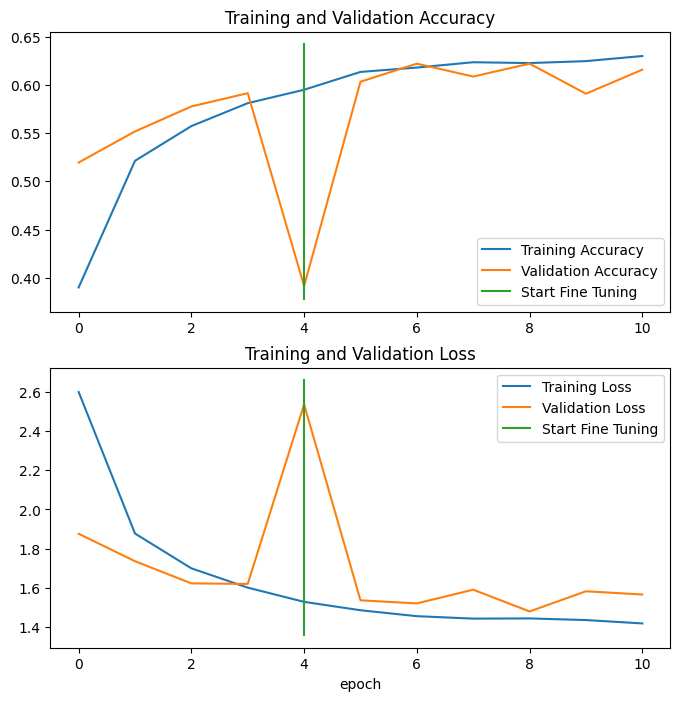

In [44]:
compare_historys(original_history=history_3,
                 new_history=histroy_efficentnet_fine_tuned,
                 initial_epochs=5)

- It seems that after fine-tuning, the model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit. 
- This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.
- If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

### 4.1 What happens if we train for more epochs??

- I'm going to implement the same feature extractor and fine tuned model but I'm going to increment the number of epochs to see what happens.
- The expected result should be better, but the training time will increase considerably by increasing the number of times the network traverses the data (increasing the epochs).

In [45]:
# Create an instance of model_3
model_4 = create_transfer_learning_model()

In [46]:
# Create checkpoint callback to save model for later use
checkpoint_path_model4 = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/101_classes_10_percent_data_model/"
checkpoint_name_model4 = "model4_checkpoint.weights.h5"

chk_callback_model4 = create_checkpoint_callback(checkpoint_path_model4,
                                                 checkpoint_name_model4)

- I'm going to create a callback for an **Earlystopping**, and, ehat means early stopping?
- The `early stopping` callback in TensorFlow is used to stop training a model when the validation metric (such as loss or accuracy) stops improving after a fixed number of consecutive epochs, called patience. This helps to prevent overfitting and save training time.

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',    # Metric to check (eg. 'val_loss', 'val_accuracy')
    patience=5,            # Number of epochs without improvement before stopping
    restore_best_weights=True  # Restore the weights of the best model at the end
)

In [48]:
# Fit the model saving checkpoints every epoch
initial_epochs = 20
history_4 = model_4.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25 * len(test_data_10_percent)), # do less steps per validation (quicker)
                        callbacks = [early_stopping,chk_callback_model4 ])

Epoch 1/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 78s 88ms/step - accuracy: 0.2836 - loss: 3.2238 - val_accuracy: 0.5244 - val_loss: 1.8618
Epoch 2/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 65s 82ms/step - accuracy: 0.5172 - loss: 1.9102 - val_accuracy: 0.5408 - val_loss: 1.7658
Epoch 3/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step - accuracy: 0.5546 - loss: 1.7337 - val_accuracy: 0.5842 - val_loss: 1.6228
Epoch 4/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.5754 - loss: 1.6215 - val_accuracy: 0.5800 - val_loss: 1.6350
Epoch 5/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5882 - loss: 1.5624

2024-12-03 18:28:33.867394: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.5882 - loss: 1.5624 - val_accuracy: 0.6087 - val_loss: 2.4204
Epoch 6/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - accuracy: 0.6036 - loss: 1.4931 - val_accuracy: 0.6054 - val_loss: 1.5293
Epoch 7/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - accuracy: 0.6126 - loss: 1.4452 - val_accuracy: 0.6043 - val_loss: 1.5544
Epoch 8/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 78ms/step - accuracy: 0.6272 - loss: 1.3992 - val_accuracy: 0.6144 - val_loss: 1.5215
Epoch 9/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.6304 - loss: 1.3806 - val_accuracy: 0.6128 - val_loss: 1.5657
Epoch 10/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.6376 - loss: 1.3577 - val_accuracy: 0.6087 - val_loss: 2.2526
Epoch 11/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.6467 - loss: 1.3244 - val_accuracy: 0.6165 - val_loss: 1.4984
Epoch 12/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step - accuracy: 0.6485 - loss: 1.3144 - val_accu

2024-12-03 18:38:19.056402: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


790/790 ━━━━━━━━━━━━━━━━━━━━ 54s 68ms/step - accuracy: 0.6584 - loss: 1.2574 - val_accuracy: 0.5217 - val_loss: 1.4752
Epoch 16/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.6652 - loss: 1.2424 - val_accuracy: 0.6250 - val_loss: 1.4789
Epoch 17/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.6669 - loss: 1.2234 - val_accuracy: 0.6261 - val_loss: 1.5162
Epoch 18/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.6707 - loss: 1.2090 - val_accuracy: 0.6324 - val_loss: 1.5064
Epoch 19/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.6741 - loss: 1.1790 - val_accuracy: 0.6324 - val_loss: 1.5747
Epoch 20/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 54s 68ms/step - accuracy: 0.6844 - loss: 1.1675 - val_accuracy: 0.6522 - val_loss: 1.1924


In [49]:
# Evaluate on the test data
results_model_4= model_4.evaluate(test_data_10_percent)
results_model_4

237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.6322 - loss: 1.4818


[1.5111963748931885, 0.6302310228347778]

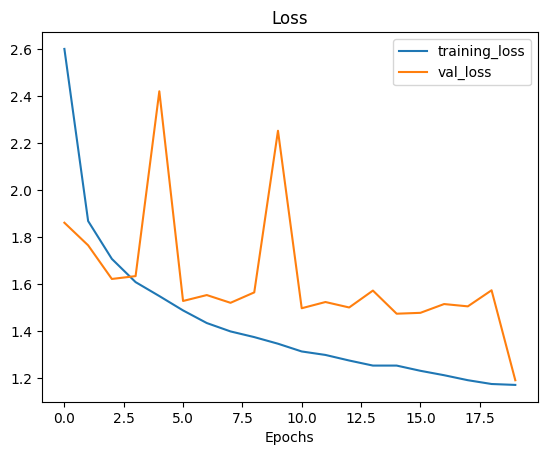

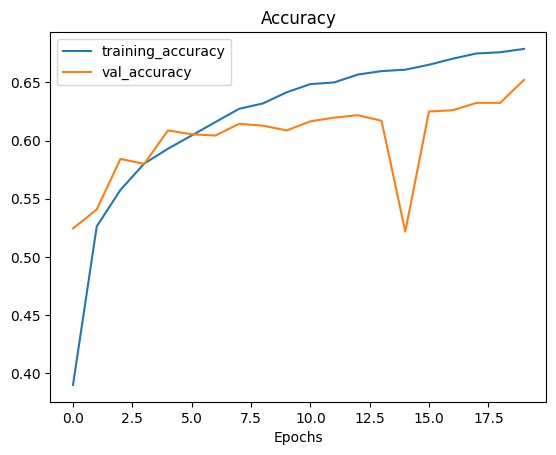

In [50]:
# Plot model loss curves
plot_loss_curves(history_4)

#### Fine tunning of the model with more epochs

In [64]:
# 1. Unfreeze all of the layers in the base model
base_model.trainable = True

# 2. Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [65]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_2 False
1 rescaling_2 False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv Fal

In [66]:
# Recompile model with lower learning rate
model_4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [67]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 30 # model has already done 20 epochs, this is the total number of epochs we're after (20+10=30)

histroy_efficentnet_fine_tuned_2 = model_4.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data_10_percent,
                                               validation_steps=int(0.15 * len(test_data_10_percent)), # validate on 15% of the test data
                                               initial_epoch=history_4.epoch[-1]) # start from previous last epoch

Epoch 20/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - accuracy: 0.6882 - loss: 1.1341 - val_accuracy: 0.6420 - val_loss: 1.4190
Epoch 21/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 72ms/step - accuracy: 0.6920 - loss: 1.1237 - val_accuracy: 0.6304 - val_loss: 1.4634
Epoch 22/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.6960 - loss: 1.1050 - val_accuracy: 0.6438 - val_loss: 1.5159
Epoch 23/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 71ms/step - accuracy: 0.7029 - loss: 1.0861 - val_accuracy: 0.6295 - val_loss: 1.4351
Epoch 24/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.6998 - loss: 1.0888 - val_accuracy: 0.6411 - val_loss: 1.4367
Epoch 25/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 56s 70ms/step - accuracy: 0.7057 - loss: 1.0744 - val_accuracy: 0.6536 - val_loss: 1.4709
Epoch 26/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.7072 - loss: 1.0723 - val_accuracy: 0.6117 - val_loss: 1.5968
Epoch 27/30
  2/790 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.6875 - loss: 1

/home/alejandro/anaconda3/envs/tensorflow_env/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.7026 - loss: 1.0781 - val_accuracy: 0.6571 - val_loss: 1.3699
Epoch 28/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 69ms/step - accuracy: 0.7131 - loss: 1.0547 - val_accuracy: 0.6339 - val_loss: 1.5075
Epoch 29/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.7015 - loss: 1.0803 - val_accuracy: 0.6411 - val_loss: 1.4740
Epoch 30/30
790/790 ━━━━━━━━━━━━━━━━━━━━ 56s 72ms/step - accuracy: 0.7079 - loss: 1.0708 - val_accuracy: 0.6393 - val_loss: 1.3860


In [68]:
# Evaluate fine-tuned model
results_all_classes_10_percent_fine_tune_2 = model_4.evaluate(test_data_10_percent)
results_all_classes_10_percent_fine_tune_2

237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.6428 - loss: 1.4361


[1.462132453918457, 0.6398679614067078]

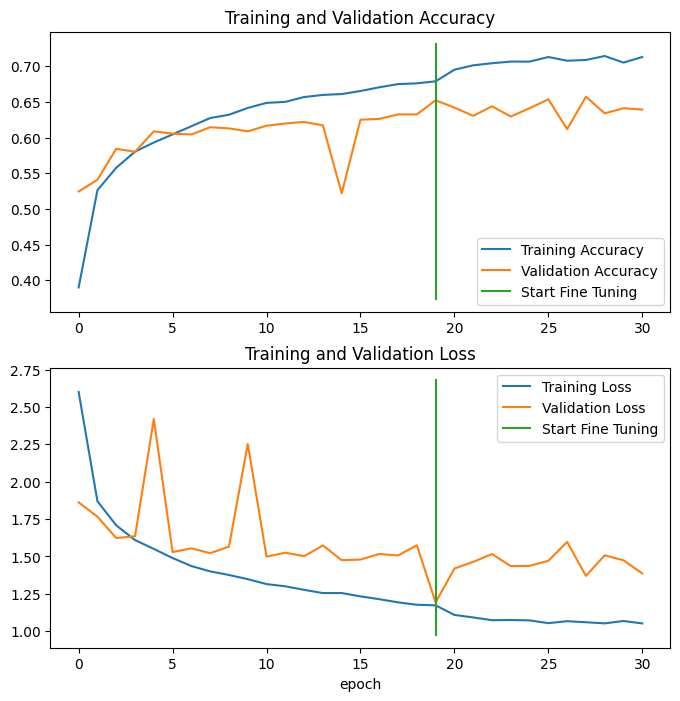

In [69]:
compare_historys(original_history=history_4,
                 new_history=histroy_efficentnet_fine_tuned_2,
                 initial_epochs=20)

In [ ]:
# # Save model to drive so it can be used later 
model_4.save("https://drive.google.com/file/d/1zQbyxcVp4SGT34FGfTkHm125KwdjIW6Z/view?usp=drive_link")

- The peaks correspond to times when the model ‘runs out of data’. I need to investigate further why this happens in order to avoid it.
- On the other hand, we see that the model improves, however the improvement is very small after 10 epochs, as the model goes from approximately 60% accuracy at 10 epochs to 64% after fine tuning.

## 5. Evaluating the performance of the best fine tuned model

### Making predictions with our trained model

- Because the model has never seen the test dataset, this should give us an indication of how the model will perform in the real world on data similar to what it has been trained on.
- To make predictions with the trained model, I used the `predict()` method passing it the test data. Since the data is multi-class, doing this will return a prediction probably tensor for each sample.

In [92]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import RandomHeight, RandomWidth

model = load_model(
    "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/101_classes_10_percent_data_model/101_food_class_10_percent_saved_big_model.h5",
    custom_objects={"RandomHeight": RandomHeight, "RandomWidth": RandomWidth}
)

In [101]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model_4.evaluate(test_data_10_percent)
loaded_loss, loaded_accuracy

237/237 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.6440 - loss: 1.4228


(1.4621326923370361, 0.6398679614067078)

In [ ]:
# Make predictions with model
pred_probs = model_4.predict(test_data_10_percent, verbose=1) # set verbosity to see how long it will take

237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step


In [108]:
# How do they look?
pred_probs[:10]

array([[6.3243060e-05, 3.1591990e-04, 2.5015592e-04, ..., 4.2548309e-05,
        1.8047858e-02, 3.4038826e-06],
       [1.7183203e-02, 4.3392298e-03, 1.3089487e-02, ..., 3.0147005e-02,
        9.5418273e-03, 2.1672403e-03],
       [7.9305191e-06, 1.6012803e-03, 1.0358604e-03, ..., 1.3432779e-05,
        6.8023629e-03, 1.9521945e-05],
       ...,
       [2.3857037e-06, 1.7163435e-06, 7.3512289e-05, ..., 9.8363780e-06,
        2.9928982e-03, 1.0566645e-06],
       [6.5343593e-09, 2.2752540e-06, 3.0390548e-09, ..., 6.8830076e-08,
        1.9075045e-05, 2.1063228e-07],
       [1.5943183e-01, 4.0418751e-04, 3.3033341e-02, ..., 2.7557582e-04,
        2.6087600e-03, 1.1837134e-02]], dtype=float32)

- Due to the nature of the softmax activation function, the sum of each of the prediction probabilities for a single sample will be 1 (or at least very close to 1)

In [110]:
pred_probs[0].sum()

np.float32(1.0)

In [111]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

In [112]:
# How do they look?
pred_classes[:10]

array([26, 72, 86, 73,  9, 82, 99, 86, 48,  0])

- Now I got the predicted class index for each of the samples in the test dataset. I will be able to compare these to the test dataset labels to further evaluate the model.
- To get the test dataset labels I unravel the `test_data_10_percent` object (which is in the form of a `tf.data.Dataset`) using the [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch) method. Doing this will give access to the images and labels in the test dataset. Since the labels are in one-hot encoded format, I need to take use of the `argmax()` method to return the index of the label

In [105]:
y_labels = []
for images, labels in test_data_10_percent.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [106]:
y_labels[:10] # check what they look like (unshuffled)

[np.int64(41),
 np.int64(23),
 np.int64(20),
 np.int64(55),
 np.int64(96),
 np.int64(7),
 np.int64(19),
 np.int64(55),
 np.int64(70),
 np.int64(26)]

### Evaluating the models predictions

To evaluate the predictions that thge model generates, I'm going to check the next parameters with the help of **Scikit-Learn** module:
- [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function which compares truth labels to predicted labels and returns an accuracy score.
- Use the `make_confusion_matrix` function which I created for generate a confusion matrix and chech the true an false positives and negatives.
- Use the Scikit-Learn's [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function.

In [107]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.010165016501650165

In [74]:
# Get the class names
class_names = test_data_10_percent.class_names

# Plot a confusion matrix with all 7575 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [75]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.01      0.01      0.01        75
           1       0.02      0.03      0.02        75
           2       0.02      0.03      0.03        75
           3       0.01      0.01      0.01        75
           4       0.01      0.01      0.01        75
           5       0.02      0.01      0.01        75
           6       0.02      0.01      0.01        75
           7       0.02      0.03      0.02        75
           8       0.02      0.03      0.02        75
           9       0.01      0.01      0.01        75
          10       0.04      0.04      0.04        75
          11       0.01      0.01      0.01        75
          12       0.00      0.00      0.00        75
          13       0.00      0.00      0.00        75
          14       0.02      0.01      0.01        75
          15       0.02      0.01      0.02        75
          16       0.01      0.01      0.01        75
          17       0.01    

### Checking the precission of the predictions

In [76]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

# Create empty dictionary
class_f1_scores = {}

# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.011627906976744186,
 'baby_back_ribs': 0.022099447513812154,
 'baklava': 0.025,
 'beef_carpaccio': 0.013986013986013986,
 'beef_tartare': 0.013605442176870748,
 'beet_salad': 0.014285714285714285,
 'beignets': 0.014388489208633094,
 'bibimbap': 0.024096385542168676,
 'bread_pudding': 0.024096385542168676,
 'breakfast_burrito': 0.011494252873563218,
 'bruschetta': 0.041379310344827586,
 'caesar_salad': 0.013333333333333334,
 'cannoli': 0.0,
 'caprese_salad': 0.0,
 'carrot_cake': 0.014925373134328358,
 'ceviche': 0.017241379310344827,
 'cheese_plate': 0.013157894736842105,
 'cheesecake': 0.012987012987012988,
 'chicken_curry': 0.029197080291970802,
 'chicken_quesadilla': 0.014925373134328358,
 'chicken_wings': 0.012738853503184714,
 'chocolate_cake': 0.01098901098901099,
 'chocolate_mousse': 0.013422818791946308,
 'churros': 0.028169014084507043,
 'clam_chowder': 0.05,
 'club_sandwich': 0.013986013986013986,
 'crab_cakes': 0.027210884353741496,
 'creme_brulee': 0.02758620

In [77]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
24           clam_chowder  0.050000
75                    pho  0.047619
10             bruschetta  0.041379
61  lobster_roll_sandwich  0.041379
93                  steak  0.041379

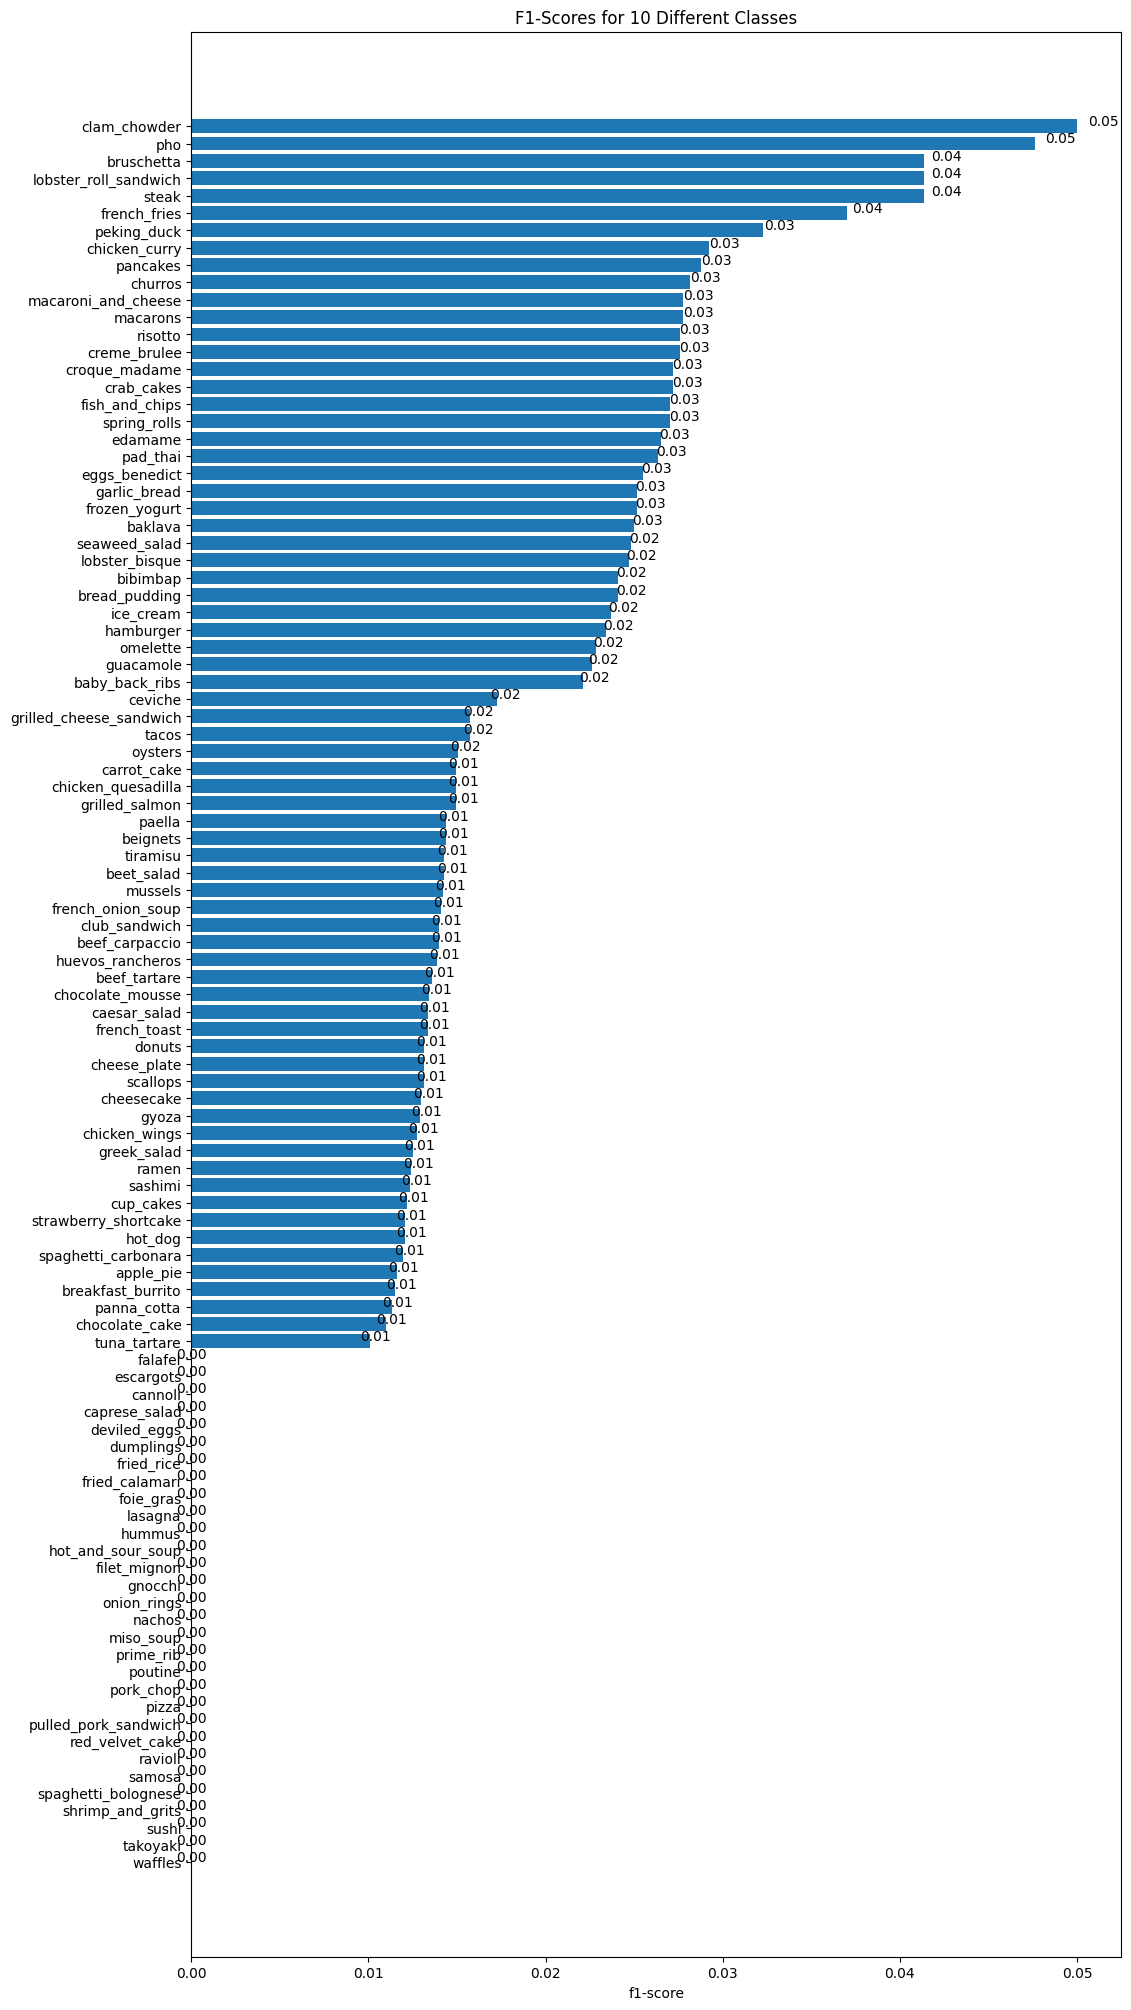

In [78]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

### Finding the most wrong predictions

I will go through the following steps:
1. Get all of the image file paths in the test dataset using the [`list_files()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [79]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data_10_percent.list_files("/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
  
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'/home/alejandro/proyectos_tensorflow/Compute...      67      74   
1  b'/home/alejandro/proyectos_tensorflow/Compute...      56      34   
2  b'/home/alejandro/proyectos_tensorflow/Compute...      96      72   
3  b'/home/alejandro/proyectos_tensorflow/Compute...      92      19   
4  b'/home/alejandro/proyectos_tensorflow/Compute...      83      86   

   pred_conf  y_true_classname    y_pred_classname  
0   0.417590          omelette         peking_duck  
1   0.401493  huevos_rancheros       eggs_benedict  
2   0.841326             tacos            pancakes  
3   0.487952      spring_rolls  chicken_quesadilla  
4   0.681036   red_velvet_cake             sashimi

In [80]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/home/alejandro/proyectos_tensorflow/Compute...      67      74   
1  b'/home/alejandro/proyectos_tensorflow/Compute...      56      34   
2  b'/home/alejandro/proyectos_tensorflow/Compute...      96      72   
3  b'/home/alejandro/proyectos_tensorflow/Compute...      92      19   
4  b'/home/alejandro/proyectos_tensorflow/Compute...      83      86   

   pred_conf  y_true_classname    y_pred_classname  pred_correct  
0   0.417590          omelette         peking_duck         False  
1   0.401493  huevos_rancheros       eggs_benedict         False  
2   0.841326             tacos            pancakes         False  
3   0.487952      spring_rolls  chicken_quesadilla         False  
4   0.681036   red_velvet_cake             sashimi         False

In [81]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
4646  b'/home/alejandro/proyectos_tensorflow/Compute...      61      33   
5704  b'/home/alejandro/proyectos_tensorflow/Compute...      39      33   
1110  b'/home/alejandro/proyectos_tensorflow/Compute...      87      69   
2422  b'/home/alejandro/proyectos_tensorflow/Compute...      94      32   
5057  b'/home/alejandro/proyectos_tensorflow/Compute...      15      63   
1803  b'/home/alejandro/proyectos_tensorflow/Compute...      78      32   
6019  b'/home/alejandro/proyectos_tensorflow/Compute...       3      63   
2211  b'/home/alejandro/proyectos_tensorflow/Compute...      80      63   
4588  b'/home/alejandro/proyectos_tensorflow/Compute...      19      33   
3051  b'/home/alejandro/proyectos_tensorflow/Compute...      83      32   
5926  b'/home/alejandro/proyectos_tensorflow/Compute...      61      69   
5205  b'/home/alejandro/proyectos_tensorflow/Compute...      78      65   
6445  b'/home/alejandro/proyectos_tensorflow/Compute...      16      88   
3841  b'/home/alejandro/proyectos_tensorflow/Compute...      97      32   
2670  b'/home/alejandro/proyectos_tensorflow/Compute...      13      33   
1383  b'/home/alejandro/proyectos_tensorflow/Compute...       7      32   
2504  b'/home/alejandro/proyectos_tensorflow/Compute...      43      32   
2802  b'/home/alejandro/proyectos_tensorflow/Compute...      40      63   
5877  b'/home/alejandro/proyectos_tensorflow/Compute...      74      33   
5921  b'/home/alejandro/proyectos_tensorflow/Compute...      87      33   

      pred_conf       y_true_classname y_pred_classname  pred_correct  
4646   1.000000  lobster_roll_sandwich          edamame         False  
5704   1.000000              foie_gras          edamame         False  
1110   1.000000               scallops          oysters         False  
2422   1.000000   strawberry_shortcake        dumplings         False  
5057   1.000000                ceviche         macarons         False  
1803   1.000000                poutine        dumplings         False  
6019   1.000000         beef_carpaccio         macarons         False  
2211   1.000000   pulled_pork_sandwich         macarons         False  
4588   1.000000     chicken_quesadilla          edamame         False  
3051   1.000000        red_velvet_cake        dumplings         False  
5926   1.000000  lobster_roll_sandwich          oysters         False  
5205   1.000000                poutine          mussels         False  
6445   1.000000           cheese_plate    seaweed_salad         False  
3841   1.000000               takoyaki        dumplings         False  
2670   1.000000          caprese_salad          edamame         False  
1383   1.000000               bibimbap        dumplings         False  
2504   1.000000         fried_calamari        dumplings         False  
2802   1.000000           french_fries         macarons         False  
5877   1.000000            peking_duck          edamame         False  
5921   0.999999               scallops          edamame         False

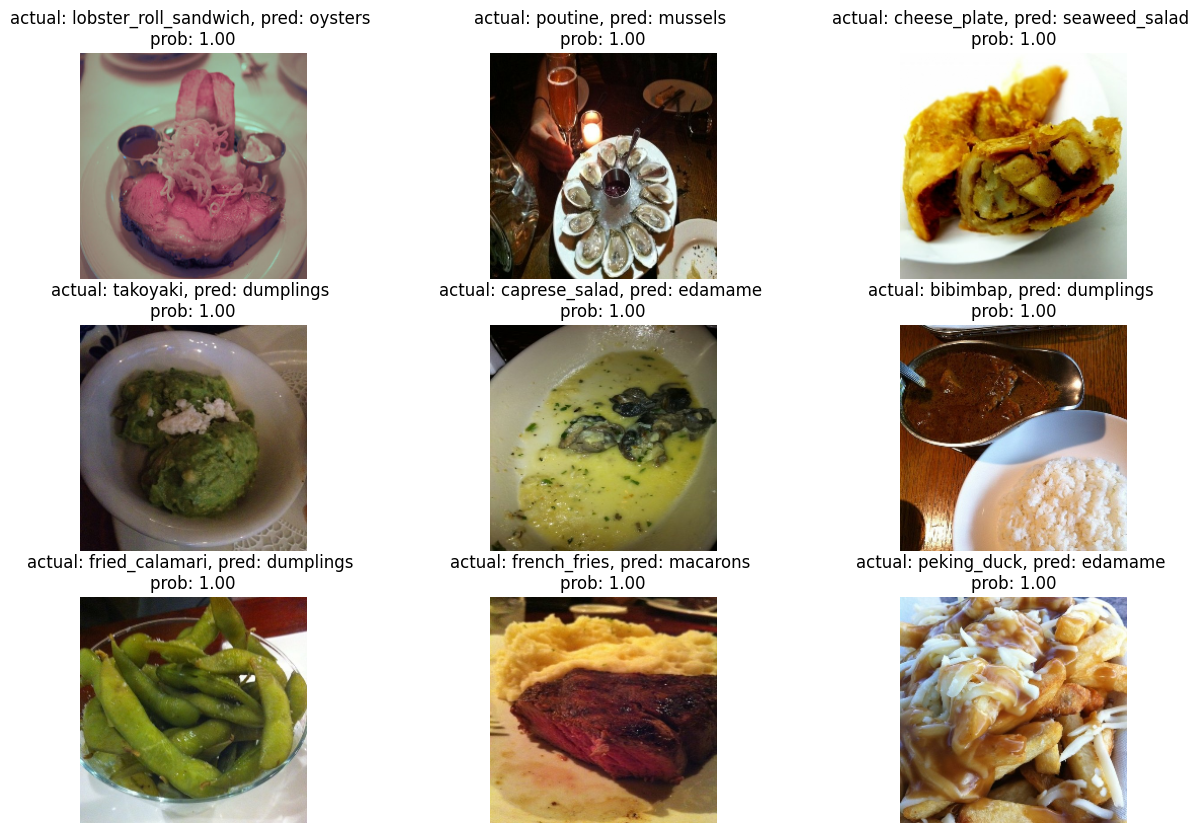

In [82]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)